## Data Visualization of Kiva NGO data

[Kiva.org](https://www.kiva.org/) is an online crowdfunding platform to extend financial services to poor and financially excluded people around the world by accepting donations online. Anybody of us can donate $ 1, $ 100 or $ 10000 sitting at home.

**Aim** of this analysis is: Use Data Visualization to locate those regions which need to be prioritized for funding because they are more economically backward than other regions. Kiva provided loan & region data, finding appropriate economical and financial data & connecting it to the loan & region data was a **part of the problem**

Summary of my approach:

1. I started with initial EDA of various information in the dataset
2. Phillipines was the country which had most of the loans so I decided to focus on it
3. Found some economic indicators for Philippines
4. Data **lot of data cleaning** to connect the external data and loan data
5. Used the combined data to locate a few regions where loan flow can be prioritized due to poverty

Tools used: R, ggplot2 and other miscellaneous helper packages for data visualization

## Notebook 2 - Borrower profiles and characteristics

* load data
* call packages

#### Q) What are the main borrower characteristics which dominate the data within different countries?

In [41]:
# read in the data
kiva_loans <- read.csv("kiva_loans.csv", header=T)
kiva_regions <- read.csv("kiva_mpi_region_locations.csv", header=T)
loan_theme_ids <- read.csv("loan_theme_ids.csv", header=T)
loan_theme_regions <- read.csv("loan_themes_by_region.csv", header=T)

library(dplyr)
library(ggplot2)

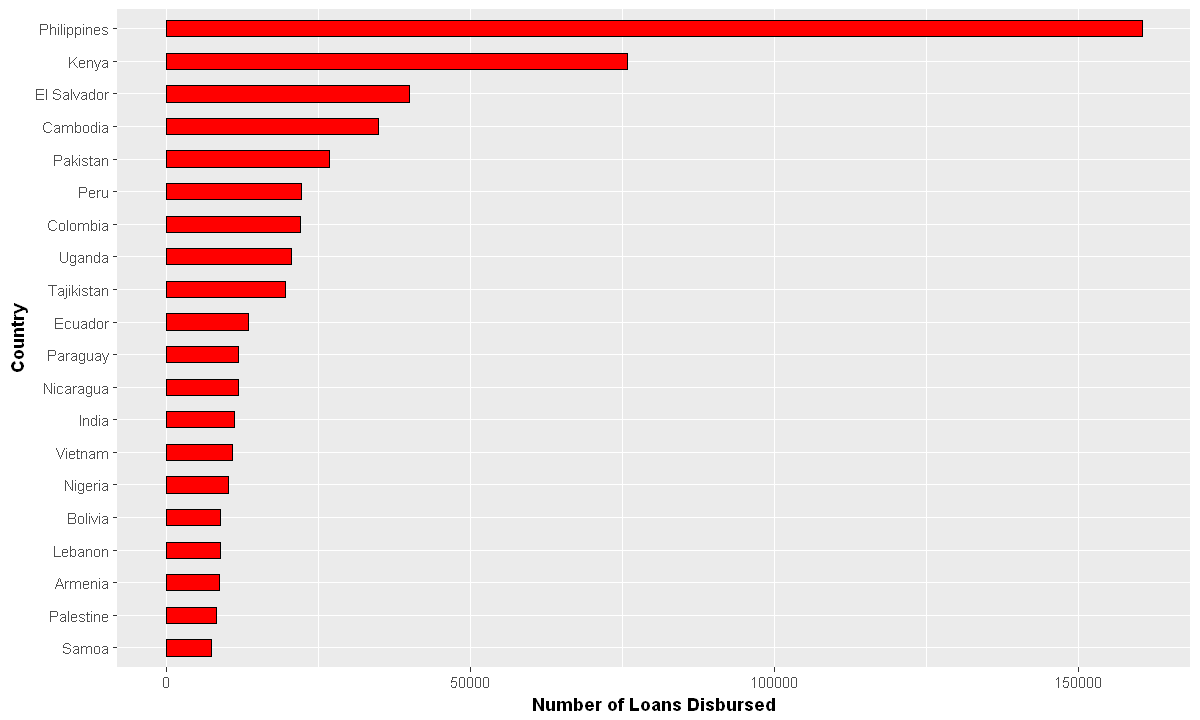

In [42]:
options(repr.plot.width=10, repr.plot.height=6)

ggplot(data = kiva_loans %>% group_by(country) %>% 
                 summarise(row_count = n_distinct(id)) %>%
                 top_n(20, row_count),
               aes(x = reorder(country, row_count), y = row_count)) +
          geom_bar(stat = "identity", width = 0.5, fill = "red", colour = "black") +
    scale_x_discrete("Country") + scale_y_continuous("Number of Loans Disbursed") +
          theme(axis.text.x = element_text(angle = 0, hjust = 0.5, vjust = 0.5),
    axis.title.y = element_text(face = "bold"), 
    axis.title.x = element_text(face = "bold")) +
    coord_flip()

* **Philippines** has the most no. of loans in this dataset followed by **Kenya** and **El Salvador**



* Q) How many % of the data do top 5 countries cover?

In [43]:
top_5_country_loan_count <- as.numeric(kiva_loans %>% filter(country %in% c("Philippines", 
                                     "Kenya",
                                    "El Salvador",
                                    "Cambodia",
                                    "Pakistan")) %>%
                summarise(n_distinct(id))
           )
total_loan_count <- length(unique(kiva_loans$id))

cat(paste("The top 5 countries cover", 
      paste(round((top_5_country_loan_count/total_loan_count),2)*100,"%",sep="") ,
      "of the total loans disbursed by KIVA so we will focus on these countries for now", sep =" "))

The top 5 countries cover 50% of the total loans disbursed by KIVA so we will focus on these countries for now

* Recall: The aim is to find regions of poverty, connect their economical characteristics with loans and filter out regions which need to be prioritized



* Let us consider only the top 5 countries for now.

### EDA of top 5 countries

#### Q) Which sectors are getting the most loans in these top 5 countries?

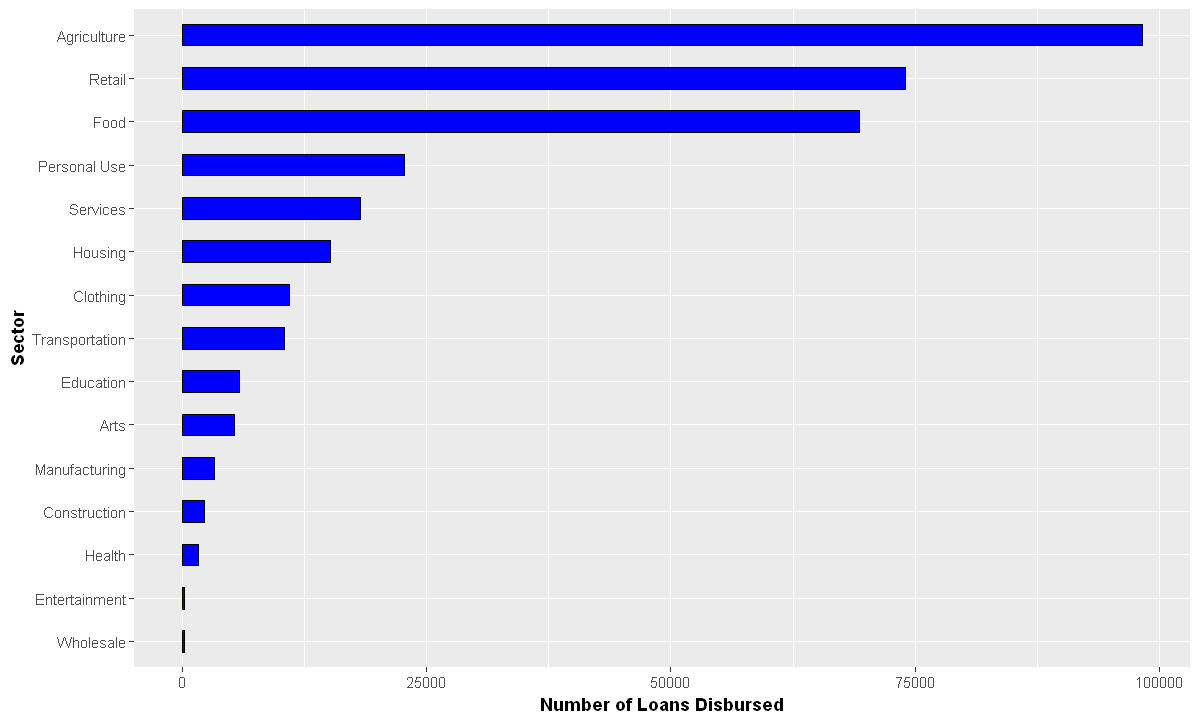

In [44]:
kiva_loans_top5 <- data.frame(kiva_loans %>% filter(country %in% c("Philippines", 
                                                        "Kenya",
                                                        "El Salvador",
                                                        "Cambodia",
                                                        "Pakistan")))

kiva_loans_top5$gender <- if_else((kiva_loans_top5$borrower_genders == "male"), "male","female")
kiva_loans$gender <- if_else((kiva_loans$borrower_genders == "male"), "male","female")

# what are the top sectors in which the loans are getting allotted?

ggplot(data = kiva_loans_top5 %>% group_by(sector) %>% 
         summarise(row_count = n_distinct(id)) %>%
         top_n(20, row_count),
       aes(x = reorder(sector, row_count), y = row_count)) +
  geom_bar(stat = "identity", width = 0.5, fill = "blue", colour = "black") +
  scale_x_discrete("Sector") + scale_y_continuous("Number of Loans Disbursed") +
  theme(axis.text.x = element_text(angle = 0, hjust = 0.5, vjust = 0.5),
        axis.title.y = element_text(face = "bold"), 
        axis.title.x = element_text(face = "bold")) +
  coord_flip()

#### Ans) AGRICULTURE, RETAIL & FOOD


* Quick check:
### What % do the top 3 sectors cover?

In [45]:
top_3_sector_perc <- (as.numeric(kiva_loans_top5 %>% filter(sector %in% c("Agriculture", 
                                                                     "Retial",
                                                                     "Food")
                                                                  ) %>%
                                  summarise(n_distinct(id))
        )/ length(unique(kiva_loans_top5$id)))*100

cat(paste(paste("The top 3 sectors cover", paste(round(top_3_sector_perc,2),"%", sep =""), "of the data", sep = " "), "so we will focus on these sectors first", sep = " "))

The top 3 sectors cover 49.61% of the data so we will focus on these sectors first

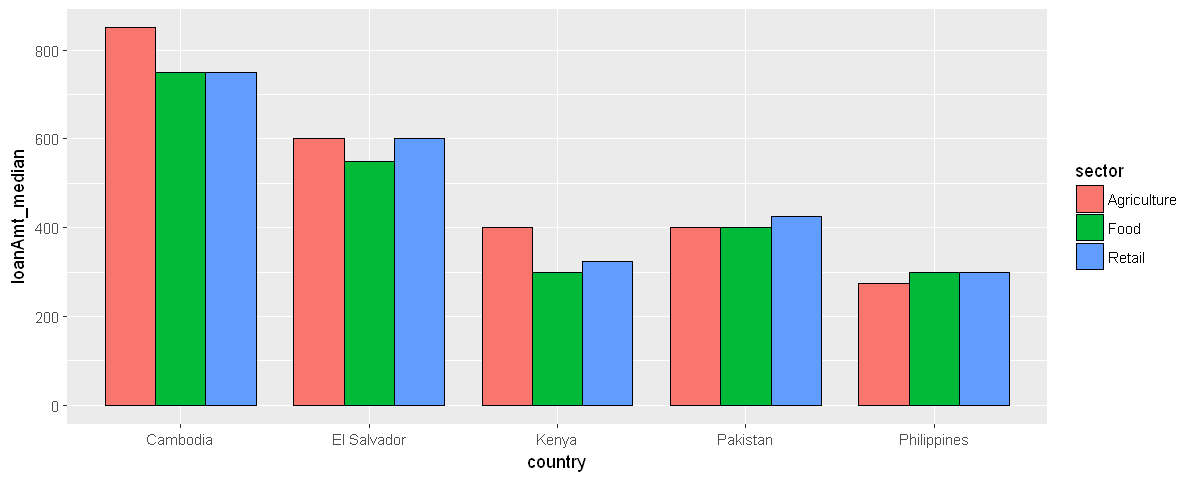

In [46]:
options(repr.plot.width=10, repr.plot.height=4)

ggplot(kiva_loans_top5 %>%
         filter(sector %in% c("Agriculture", 
                              "Retail",
                              "Food")) %>% 
         group_by(country, sector) %>%
         summarise(loanAmt_median = median(loan_amount)), aes(x = country, loanAmt_median)) +   
  geom_bar(aes(fill = sector), colour = "black", 
            width = 0.8, position = "dodge", stat="identity")

* Observations:

1.Cambodia and El Salvador has high median loan amounts for all the top 3 sectors


2.Philippines has the lowest

* **Note that [Philippines-Agriculture] has the highest share of the data yet lowest loan amount medians among top 5 countries**


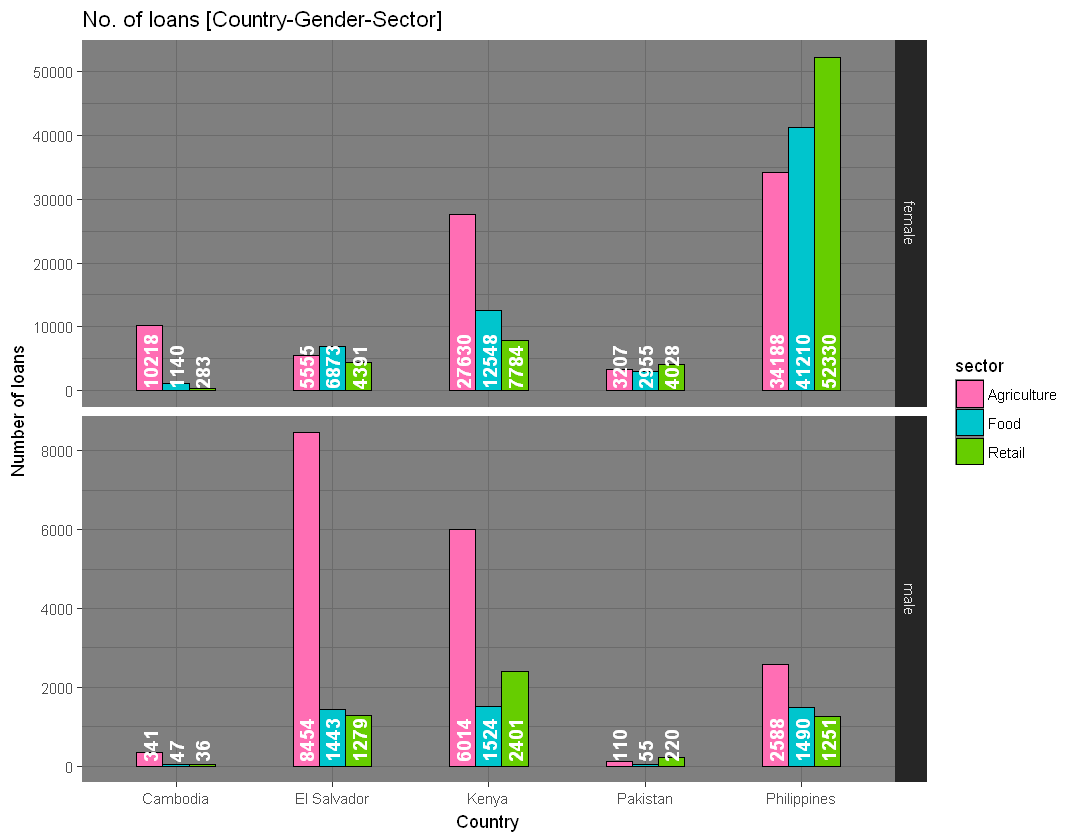

In [47]:
options(repr.plot.width=9, repr.plot.height=7)
ggplot(kiva_loans_top5 %>%
         filter(sector %in% c("Agriculture", 
                              "Retail",
                              "Food")) %>% 
         group_by(country, sector, gender) %>%
         summarise(num_loans = n_distinct(id)), aes(x = country, num_loans, group = sector)) +   
  geom_bar(aes(fill = sector), colour = "black", 
            width = 0.5, position = "dodge", stat="identity") +
geom_text(aes(y=100, label = as.character(num_loans)),  position = position_dodge(0.5), hjust = 0, size = 4, angle = 90,
          vjust = 0.5, colour = "white", fontface = "bold") +
scale_fill_manual(values = c("hotpink1","turquoise3","chartreuse3")) +
ggtitle("No. of loans [Country-Gender-Sector]") +
scale_y_continuous("Number of loans") + scale_x_discrete("Country") +
    facet_grid(gender ~., scales = "free") +
    theme(plot.title = element_text(hjust = 0.5)) + theme_dark()

* **We further infer from the above plot that [Philippines-Agriculture-Female] segment is:**



1. Very high in numbers
2. They have low median loan amounts amongst all other top 5 countries



* **This might indicate a segment with poverty. We will dig in deeper in this segment and try to find online data of economic indicators for Philippines sub-regions especially indicators w.r.t Agriculture and Female**

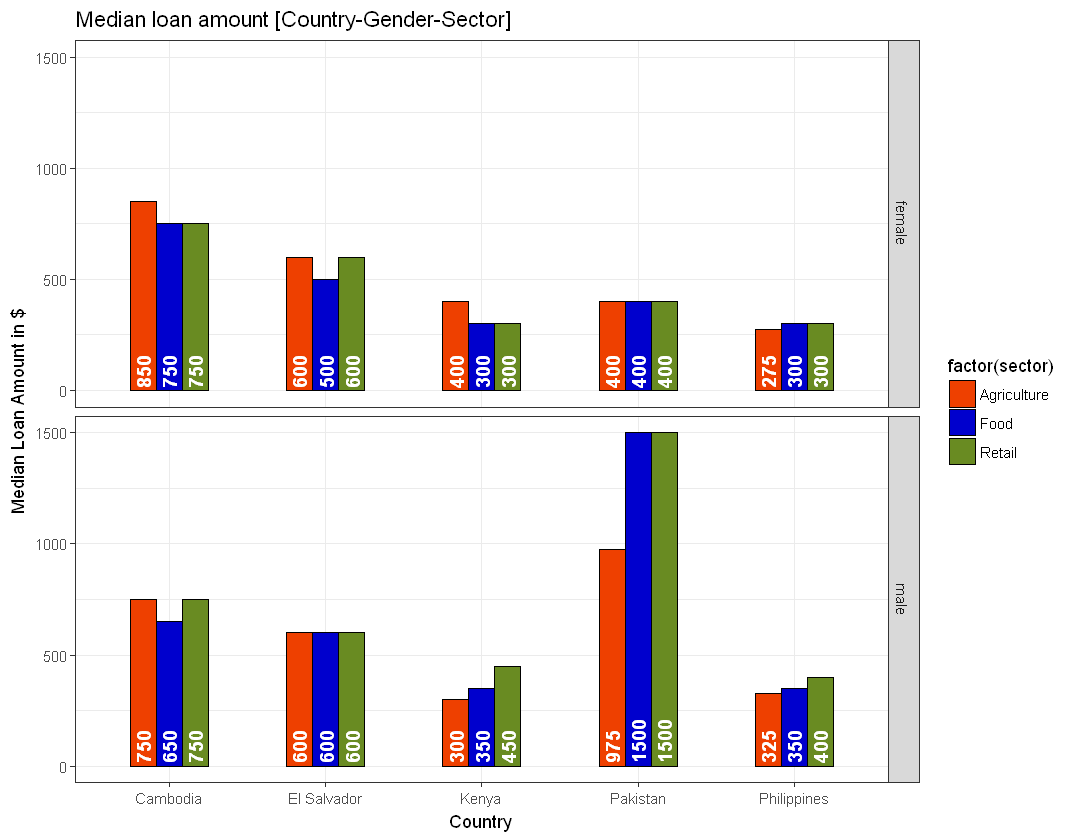

In [48]:
options(repr.plot.width=9, repr.plot.height=7)
ggplot(kiva_loans_top5 %>%
         filter(sector %in% c("Agriculture", 
                              "Retail",
                              "Food")) %>% 
         group_by(country, sector, gender) %>%
         summarise(loanAmt_median = median(loan_amount)), aes(x = country, loanAmt_median, group = sector)) +   
  geom_bar(aes(fill = factor(sector)), colour = "black", width = 0.5, position = "dodge", stat="identity") +
geom_text(aes(y=10, label = as.character(loanAmt_median)),  position = position_dodge(0.5), hjust = 0, size = 4, angle = 90, vjust = 0.5, colour = "white", fontface = "bold") +
scale_fill_manual(values = c("orangered2","blue3","olivedrab4")) +
ggtitle("Median loan amount [Country-Gender-Sector]") +
scale_y_continuous("Median Loan Amount in $") + scale_x_discrete("Country") +
facet_grid(gender ~.) +
    theme(plot.title = element_text(hjust = 0.5)) + theme_bw()

* Reiterating the point that Philippines-females have teribly low median loan amounts despite having a high no. of loans figure

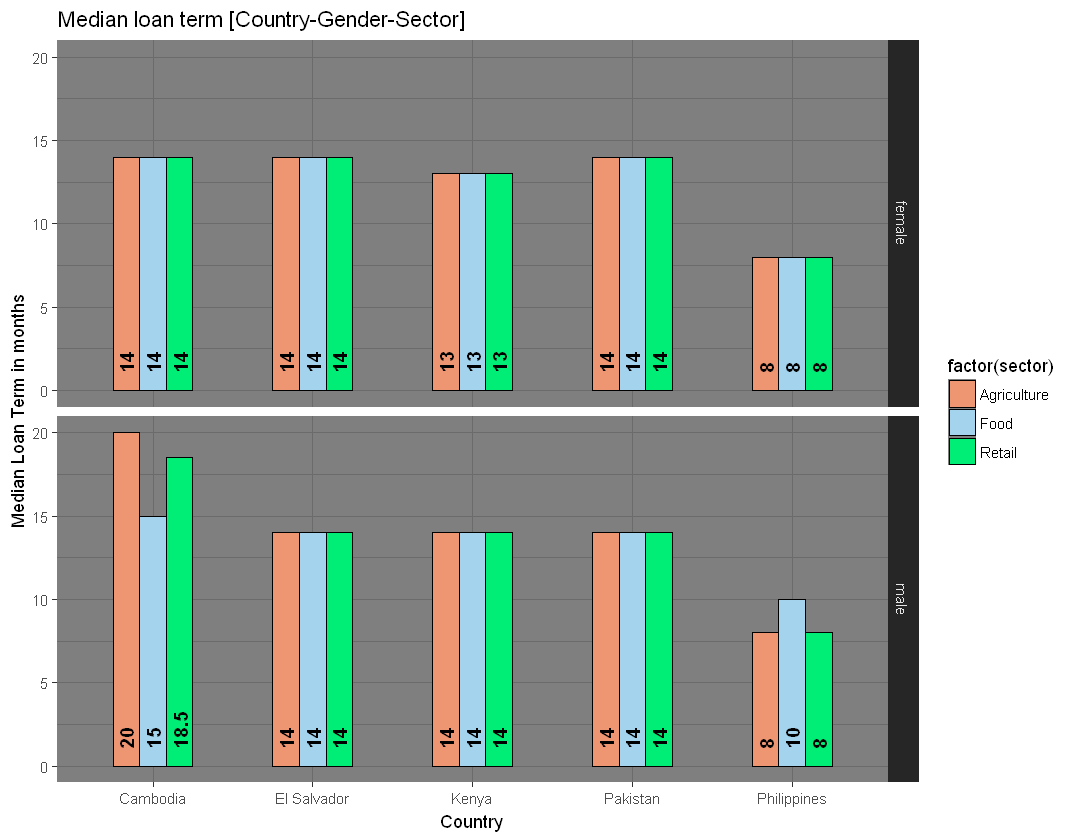

In [49]:
options(repr.plot.width=9, repr.plot.height=7)
ggplot(kiva_loans_top5 %>%
         filter(sector %in% c("Agriculture", 
                              "Retail",
                              "Food")) %>% 
         group_by(country, sector, gender) %>%
         summarise(loanTerm_median = median(term_in_months)), aes(x = country, loanTerm_median, group = sector)) +   
  geom_bar(aes(fill = factor(sector)), colour = "black", width = 0.5, position = "dodge", stat="identity") +
 geom_text(aes(y=1, label = as.character(loanTerm_median)),  position = position_dodge(0.5), hjust = 0, size = 4, angle = 90, vjust = 0.5, colour = "black", fontface = "bold") +
  scale_fill_manual(values = c("lightsalmon2","lightskyblue2","springgreen2")) +
    ggtitle("Median loan term [Country-Gender-Sector]") +
scale_y_continuous("Median Loan Term in months") + scale_x_discrete("Country") +
    facet_grid(gender ~.) +
    theme(plot.title = element_text(hjust = 0.5)) + theme_dark()

* And low number of meidan loan terms as well w.r.t outher countries

### In the next notebook - Notebook 3, we will connect a dataset for economic indicators of Phillipines sub-regions for agriculture households and compare those with the loan characteristics.

### We will identify certrain regions for prioritizing loans in Phillipines which are economically backward than other regions

### Stay tuned